Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice_raw.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

# Preprocess

In [6]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [7]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [9]:
def Get_Dataset(TEST):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j])
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

# Evaluate

In [10]:
import itertools

In [11]:
Models = ['GRU'] #['LSTM', 'GRU', 'RNN', 'BiLSTM', 'BiGRU', 'BiRNN']

In [12]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

TEST
Mouse 2


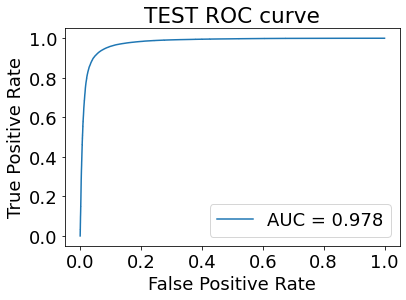

AUC: 0.978
Optimal threshold: 0.514
215640/215640 [==============================] - 51s 236us/sample - loss: 0.1784 - acc: 0.9355
TEST
Mouse 3


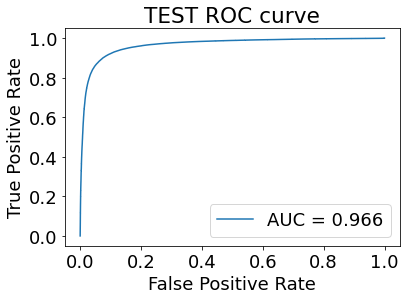

AUC: 0.966
Optimal threshold: 0.606
251580/251580 [==============================] - 61s 244us/sample - loss: 0.2445 - acc: 0.9140
TEST
Mouse 4


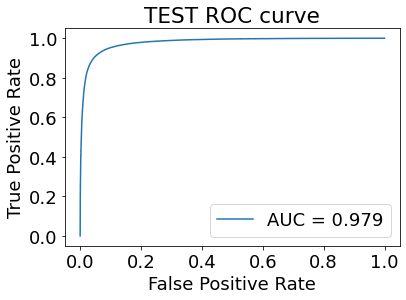

AUC: 0.979
Optimal threshold: 0.535
269550/269550 [==============================] - 64s 239us/sample - loss: 0.2030 - acc: 0.9312
TEST
Mouse 5


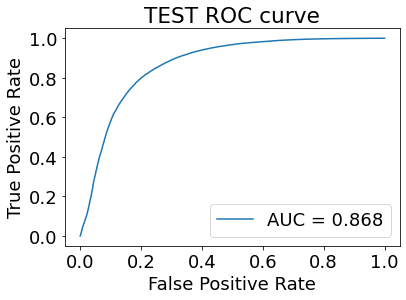

AUC: 0.868
Optimal threshold: 0.692
215640/215640 [==============================] - 51s 239us/sample - loss: 0.4056 - acc: 0.8472
TEST
Mouse 1


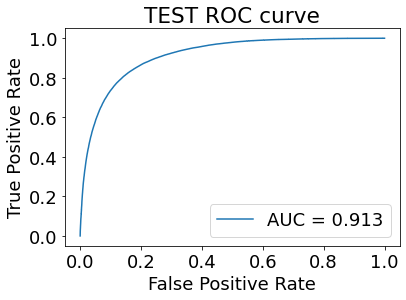

AUC: 0.913
Optimal threshold: 0.235
197670/197670 [==============================] - 48s 242us/sample - loss: 0.3846 - acc: 0.8297
TEST
Mouse 3


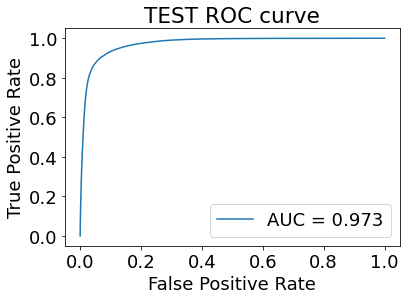

AUC: 0.973
Optimal threshold: 0.511
251580/251580 [==============================] - 59s 236us/sample - loss: 0.2090 - acc: 0.9176
TEST
Mouse 4


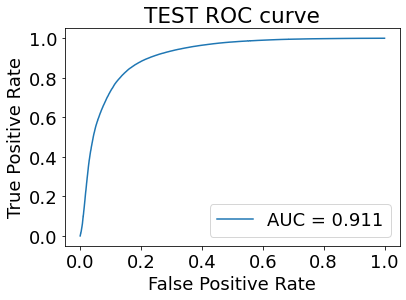

AUC: 0.911
Optimal threshold: 0.571
269550/269550 [==============================] - 63s 235us/sample - loss: 0.4350 - acc: 0.8479
TEST
Mouse 5


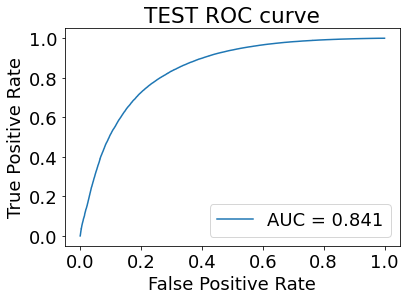

AUC: 0.841
Optimal threshold: 0.798
215640/215640 [==============================] - 51s 236us/sample - loss: 0.3640 - acc: 0.8544
TEST
Mouse 1


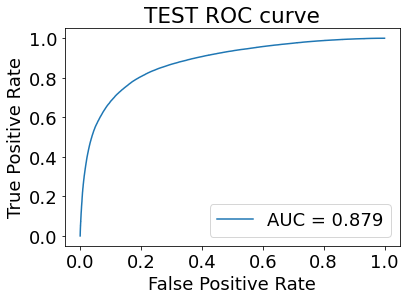

AUC: 0.879
Optimal threshold: 0.438
197670/197670 [==============================] - 47s 236us/sample - loss: 0.4228 - acc: 0.8164
TEST
Mouse 2


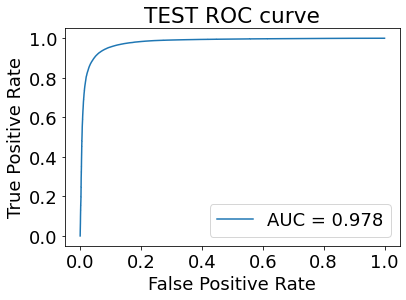

AUC: 0.978
Optimal threshold: 0.469
215640/215640 [==============================] - 51s 236us/sample - loss: 0.2013 - acc: 0.9319
TEST
Mouse 4


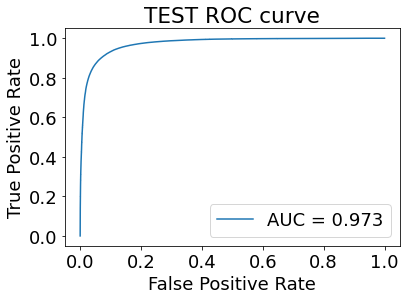

AUC: 0.973
Optimal threshold: 0.415
269550/269550 [==============================] - 64s 237us/sample - loss: 0.2270 - acc: 0.9146
TEST
Mouse 5


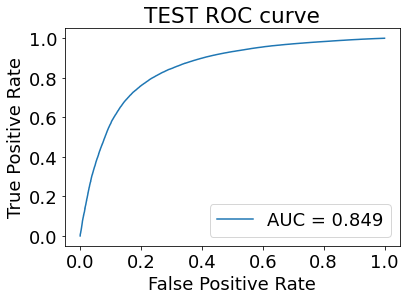

AUC: 0.849
Optimal threshold: 0.876
215640/215640 [==============================] - 51s 236us/sample - loss: 0.4197 - acc: 0.8467
TEST
Mouse 1


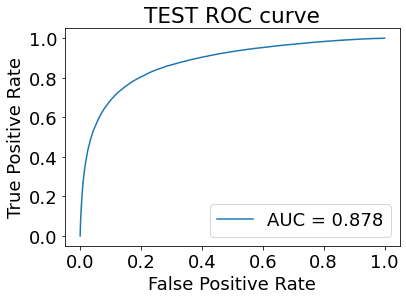

AUC: 0.878
Optimal threshold: 0.401
197670/197670 [==============================] - 46s 235us/sample - loss: 0.4164 - acc: 0.8218
TEST
Mouse 2


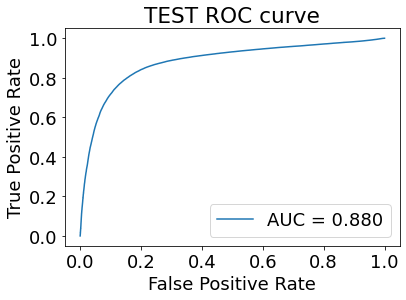

AUC: 0.880
Optimal threshold: 0.275
215640/215640 [==============================] - 51s 238us/sample - loss: 0.6233 - acc: 0.7755
TEST
Mouse 3


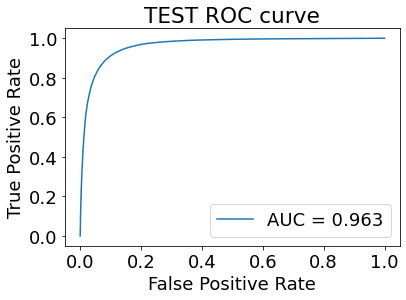

AUC: 0.963
Optimal threshold: 0.240
251580/251580 [==============================] - 60s 239us/sample - loss: 0.2985 - acc: 0.8925
TEST
Mouse 5


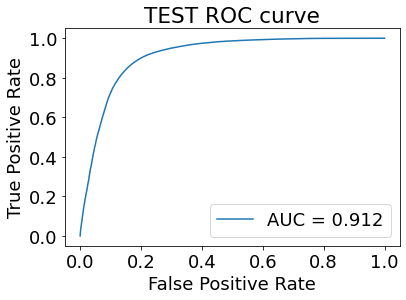

AUC: 0.912
Optimal threshold: 0.854
215640/215640 [==============================] - 52s 239us/sample - loss: 0.2825 - acc: 0.9027
TEST
Mouse 1


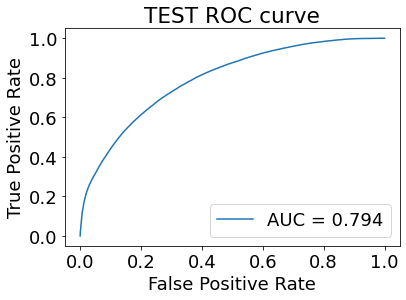

AUC: 0.794
Optimal threshold: 0.734
197670/197670 [==============================] - 47s 239us/sample - loss: 0.7788 - acc: 0.6653
TEST
Mouse 2


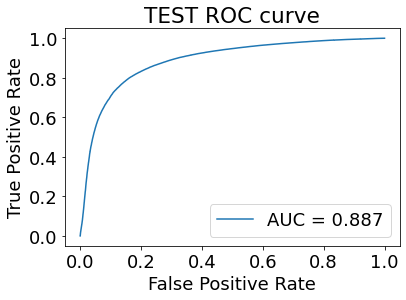

AUC: 0.887
Optimal threshold: 0.358
215640/215640 [==============================] - 51s 239us/sample - loss: 0.5843 - acc: 0.7947
TEST
Mouse 3


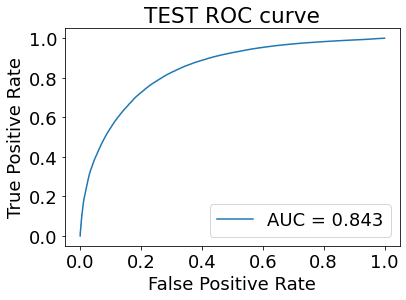

AUC: 0.843
Optimal threshold: 0.306
251580/251580 [==============================] - 54s 214us/sample - loss: 0.6801 - acc: 0.7375
TEST
Mouse 4


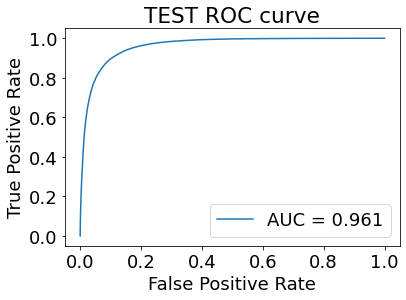

AUC: 0.961
Optimal threshold: 0.498
269550/269550 [==============================] - 66s 244us/sample - loss: 0.2662 - acc: 0.8994


In [13]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 3]), columns=['VALID','TEST']+Models)
df_LOSS = pandas.DataFrame(numpy.zeros([20, 3]), columns=['VALID','TEST']+Models)
df_ACC = pandas.DataFrame(numpy.zeros([20, 3]), columns=['VALID','TEST']+Models)

l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TRAIN = [i for i in l if i not in v]
    VALID = [v[0]]
    TEST = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    testX, testY = Get_Dataset(TEST)
    input_test = testX.transpose(0,2,1)
    for ModelType in Models:
        ver = f'{ModelType}_{VALID}_{TEST}'
        model_file_path = f'models_N20/{ModelType}/best_model_{ver}.h5'
        model = load_model(model_file_path)
        test_pred = model.predict(input_test)
        df_AUC[ModelType][raw] = plot_roc(test_pred, testY, "TEST")
        results = model.evaluate(input_test,testY)
        df_LOSS[ModelType][raw] = results[0]
        df_ACC[ModelType][raw] = results[1]

In [14]:
df_AUC.to_csv('N20_models_result_AUC.csv')
df_AUC

,VALID,TEST,GRU
0,2.0,1.0,0.978389
1,3.0,1.0,0.965823
2,4.0,1.0,0.979126
3,5.0,1.0,0.868475
4,1.0,2.0,0.912799
5,3.0,2.0,0.972667
6,4.0,2.0,0.910850
7,5.0,2.0,0.841385
8,1.0,3.0,0.879265
9,2.0,3.0,0.978251


In [15]:
df_LOSS.to_csv('N20_models_result_BCEloss.csv')
df_LOSS

,VALID,TEST,GRU
0,2.0,1.0,0.178360
1,3.0,1.0,0.244488
2,4.0,1.0,0.203008
3,5.0,1.0,0.405646
4,1.0,2.0,0.384589
5,3.0,2.0,0.208956
6,4.0,2.0,0.434966
7,5.0,2.0,0.363982
8,1.0,3.0,0.422817
9,2.0,3.0,0.201342


In [16]:
df_ACC.to_csv('N20_models_result_Accuracy.csv')
df_ACC

,VALID,TEST,GRU
0,2.0,1.0,0.935462
1,3.0,1.0,0.913980
2,4.0,1.0,0.931245
3,5.0,1.0,0.847157
4,1.0,2.0,0.829721
5,3.0,2.0,0.917645
6,4.0,2.0,0.847909
7,5.0,2.0,0.854438
8,1.0,3.0,0.816376
9,2.0,3.0,0.931859
